## NHIS Recoding

This notebook loads data from the 2018 National Health Interview Survey and recodes it according to the coding scheme in `src/coding_pums.py`.

Information on NHIS can be found here: https://www.cdc.gov/nchs/nhis/1997-2018.htm

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd

from collections import Counter

from src import pdf, plots, coding_pums as CODING

### User Parameters

In [2]:
# where all input files are stored
DATA_DIR = 'data'

# whether to drop rows with ages < 18
ADULTS_ONLY = True

# recoded PUMS file, needed to filter recoded NHIS tuples to those actually occurring in the PUMS data
# (assumed to be located in the data directory)
PUMS_RECODED_FILENAME = 'pums_usa_2020_recoded.csv'

# map of variable enum to column name in recoded pums file
PUMS_DATA = [
    # variable enum,              # recoded PUMS var name
    (CODING.Variables.AGE,        'Age'),          
    (CODING.Variables.RACE_ETH,   'RaceEth'),
    (CODING.Variables.INSURANCE,  'Insurance'),
    (CODING.Variables.EDUCATION,  'Education'),
    (CODING.Variables.INCOME,     'Income'),
    (CODING.Variables.SEX,        'Sex'),
]

# The NHIS data for consists of multiple files that need to be merged.
# There are identifiers for each household, family, and person to facilitate merging.
# An individual is uniquely identified by the combination of these three identifiers.

# Household identifier column: 'HHX'
# Family identifier column:    'FMX'
# Person identifier column:    'FPX'

PERSONS_FILENAME  = 'nhis_2018_personsx.csv'

# extract these cols from the PERSONS file
PERSONS_VARS = [
    'HHX',      # Household identifier
    'FMX',      # Family within the household identifier
    'FPX',      # Person within the family identifier
    'SEX',      # HHC.110_00.000 Sex of the person
    'AGE_P',    # HHC.420_00.000 Age of the person
    'ORIGIN_I', # HHC.170_00.000 Hispanic ethnicity
    'MRACBPI2', # HHC.200_01.000 Race coded to single/multiple race group
    'EDUC1',    # FSD.010_00.000 Highest level of school completed
    'COVER' ,   # FHI.070_00.000 Health insurance hierarchy under 65 (missing 12913) 
    'COVER65',  # FHI.070_00.000 Health insurance hierarchy over 65 (missing 59920)
    'WTFA',     # IDN.000_70.000 Weight - final annual
]

INCOME_FILENAME  = 'nhis_2018_incmimp1.dat'
# other NHIS data files not needed

# these columns identify the unique individuals
INDEX_COLS = ['HHX', 'FMX', 'FPX']

# whether to drop rows representing people NOT in the PUMS population
# (i.e. PUMS has no entries with missing insurance coverage, for instance)
MATCH_PUMS_CATEGORIES = True

#### Load the PUMS file

In [3]:
PUMS_FILE = os.path.join(DATA_DIR, PUMS_RECODED_FILENAME)
print('Loading file "{0}"...'.format(PUMS_FILE))
raw_df = pd.read_csv(PUMS_FILE)
# extract desired columns
keep_cols = [tup[1] for tup in PUMS_DATA]
pums_df = raw_df[keep_cols].copy()
pums_df

Loading file "data/pums_usa_2020_recoded.csv"...


,Age,RaceEth,Insurance,Education,Income,Sex
0,6,0,0,5,3,1
1,6,0,0,5,2,1
2,2,0,0,3,0,0
3,2,0,1,1,0,0
4,1,3,0,2,0,1
...,...,...,...,...,...,...
2136799,3,4,1,2,2,1
2136800,3,0,0,5,1,1
2136801,3,0,0,3,1,0
2136802,2,0,0,1,2,0


#### Load the PERSONS file

In [4]:
persons_file = os.path.join(DATA_DIR, PERSONS_FILENAME)
raw_persons_df = pd.read_csv(persons_file)
# # extract desired columns and sort by identifier
persons_df = raw_persons_df[PERSONS_VARS]
persons_df.sort_values(by=INDEX_COLS, ascending=True)
persons_df

,HHX,FMX,FPX,SEX,AGE_P,ORIGIN_I,MRACBPI2,EDUC1,COVER,COVER65,WTFA
0,1,1,1,2,79,2,1,9,NaN,4.0,3539
1,4,1,1,2,55,2,1,14,1.0,NaN,5656
2,4,1,2,1,49,2,1,15,1.0,NaN,5848
3,4,1,3,1,16,2,1,10,1.0,NaN,5886
4,6,1,1,1,37,2,1,21,1.0,NaN,6009
...,...,...,...,...,...,...,...,...,...,...,...
72826,55557,1,1,2,49,2,2,5,4.0,NaN,7146
72827,55560,1,1,2,40,2,1,18,1.0,NaN,7902
72828,55562,1,1,2,61,2,1,18,1.0,NaN,7421
72829,55562,1,2,1,66,2,1,18,NaN,1.0,6485


#### Load the inputed income file

In [5]:
# The relevant fields are located at these character offsets:
# (see https://www.cdc.gov/nchs/data/nhis/incmimp_summary18.pdf)
#
#     HHX:      6-11
#     FMX:      12-13
#     FPX:      14-15
#     ERNYR_I2: 38-43 # person's total earnings in last year

hhx_data = []
fmx_data = []
fpx_data = []
inc_data = []
with open(os.path.join(DATA_DIR, INCOME_FILENAME), 'rt') as infile:
    for line in infile:
        if 0 == len(line):
            continue
        assert len(line) >= 34
        hhx = int(line[6:12])
        fmx = int(line[12:14])
        fpx = int(line[14:16])
        inc_str = line[38:44]
        if inc_str.isspace():
            # missing
            inc = math.nan
        else:
            inc = float(line[38:44])

        hhx_data.append(hhx)
        fmx_data.append(fmx)
        fpx_data.append(fpx)
        inc_data.append(inc)

# check some basic statistics to make sure the data was loaded correctly
# (see the final page of this document: https://www.cdc.gov/nchs/data/nhis/datdoc18.pdf)
inc_data = np.array(inc_data)
inc_check = inc_data[~np.isnan(inc_data)]
minval = np.min(inc_check)
maxval = np.max(inc_check)
meanval = np.mean(inc_check)
stdval = np.std(inc_check)

assert 37196 == len(inc_check)
assert 1 == minval
assert np.isclose(minval, [1])
assert np.isclose(maxval, [149000])
assert np.isclose(meanval, [48424.48])
# differs from value in the documentation: 39335.742
assert np.isclose(stdval, [39335.213])

"""
Recode the income values as follows:

class Income(Enum):
    INC_LT_25   = 0  # Less than $25K
    INC_25_50   = 1  # $25K to $49,999
    INC_50_100  = 2  # $50K to $99,999
    INC_GT_100  = 3  # $100K or more
    INC_MISSING = 4  # Missing

"""

recoded_income = []
for inc in inc_data:
    if np.isnan(inc):
        # missing
        recoded_inc = CODING.Income.INC_MISSING.value
    else:        
        if inc < 25000.0:
            recoded_inc = CODING.Income.INC_LT_25.value
        elif inc >= 25000.0 and inc < 50000.0:
            recoded_inc = CODING.Income.INC_25_50.value
        elif inc >= 50000.0 and inc < 100000.0:
            recoded_inc = CODING.Income.INC_50_100.value
        else:
            recoded_inc = CODING.Income.INC_GT_100.value
            
    recoded_income.append(recoded_inc)

income_data = {
    'HHX'    : hhx_data,
    'FMX'    : fmx_data,
    'FPX'    : fpx_data,
    'Income' : recoded_income,
}

income_df = pd.DataFrame(income_data)
income_df

,HHX,FMX,FPX,Income
0,1,1,1,4
1,4,1,1,4
2,4,1,2,1
3,4,1,3,4
4,6,1,1,3
...,...,...,...,...
72826,55557,1,1,4
72827,55560,1,1,0
72828,55562,1,1,2
72829,55562,1,2,2


#### Merge to create final dataframe

In [6]:
merged_df = pd.merge(persons_df, income_df, on=INDEX_COLS)
merged_df

,HHX,FMX,FPX,SEX,AGE_P,ORIGIN_I,MRACBPI2,EDUC1,COVER,COVER65,WTFA,Income
0,1,1,1,2,79,2,1,9,NaN,4.0,3539,4
1,4,1,1,2,55,2,1,14,1.0,NaN,5656,4
2,4,1,2,1,49,2,1,15,1.0,NaN,5848,1
3,4,1,3,1,16,2,1,10,1.0,NaN,5886,4
4,6,1,1,1,37,2,1,21,1.0,NaN,6009,3
...,...,...,...,...,...,...,...,...,...,...,...,...
72826,55557,1,1,2,49,2,2,5,4.0,NaN,7146,4
72827,55560,1,1,2,40,2,1,18,1.0,NaN,7902,0
72828,55562,1,1,2,61,2,1,18,1.0,NaN,7421,2
72829,55562,1,2,1,66,2,1,18,NaN,1.0,6485,2


In [7]:
# drop the identifier columns, no longer needed
nhis_df = merged_df.drop(columns=INDEX_COLS)
# sort cols in alphabetical order
nhis_df = nhis_df.sort_index(axis='columns')


if ADULTS_ONLY:
    nhis_df = nhis_df[nhis_df['AGE_P'] >= 18]
    nhis_df = nhis_df.reset_index(drop=True)
    
nhis_df

,AGE_P,COVER,COVER65,EDUC1,Income,MRACBPI2,ORIGIN_I,SEX,WTFA
0,79,NaN,4.0,9,4,1,2,2,3539
1,55,1.0,NaN,14,4,1,2,2,5656
2,49,1.0,NaN,15,1,1,2,1,5848
3,37,1.0,NaN,21,3,1,2,1,6009
4,36,1.0,NaN,18,3,1,2,2,5738
...,...,...,...,...,...,...,...,...,...
56160,49,4.0,NaN,5,4,2,2,2,7146
56161,40,1.0,NaN,18,0,1,2,2,7902
56162,61,1.0,NaN,18,2,1,2,2,7421
56163,66,NaN,1.0,18,2,1,2,1,6485


#### Drop rows representing people not in the PUMS population

Any rows in the NHIS data with characteristics NOT present in the PUMS population will be given a weight of zero.

One way to avoid this is to just drop those rows from the NHIS data. Another way is to devise a different coding scheme so that everybody in the recoded NHIS dataset can be found in the recoded PUMS dataset.

In [8]:
if MATCH_PUMS_CATEGORIES:
    
    delete_indices = []
    
    # PUMS does not have any missing insurance coverage values.
    # Find the indices of all rows where BOTH the COVER and COVER65 values are missing.
    sub_df = nhis_df[['COVER','COVER65']]
  
    # count NaNs across the columns in each row
    count_df = sub_df.isnull().sum(axis=1)
    
    # find rows where both are missing
    delete_series = count_df.loc[count_df == 2]
    for i in range(len(delete_series)):
        delete_indices.append(delete_series.index[i])
    
    # PUMS also does not have an UNKNOWN value for insurance coverage. Drop these rows also.
    # UNKNOWN insurance values: COVER==5 or COVER65==7
    count_df = nhis_df[(nhis_df['COVER'] == 5) | (nhis_df['COVER65'] == 7)]
    for index, row in count_df.iterrows():
        delete_indices.append(index)
    print('Dropping {0} rows with insurance values not in PUMS...'.format(len(delete_indices)))        
        
    # drop MISSING education values (97, 98, and 99)
    missing_ed_df = nhis_df[(nhis_df['EDUC1'].isin([97, 98, 99]))]
    for index, row in missing_ed_df.iterrows():
        delete_indices.append(index)
    print('Dropping {0} rows with education values coded as missing...'.format(len(missing_ed_df)))
    
    delete_indices = set(delete_indices)
    delete_indices = sorted(list(delete_indices))
    
    # drop these rows from the nhis_df and reindex
    nhis_df = nhis_df.drop(nhis_df.index[delete_indices])    
    nhis_df = nhis_df.reset_index(drop=True)

Dropping 635 rows with insurance values not in PUMS...
Dropping 709 rows with education values coded as missing...


#### Dataframe prior to recoding

In [9]:
nhis_df

,AGE_P,COVER,COVER65,EDUC1,Income,MRACBPI2,ORIGIN_I,SEX,WTFA
0,79,NaN,4.0,9,4,1,2,2,3539
1,55,1.0,NaN,14,4,1,2,2,5656
2,49,1.0,NaN,15,1,1,2,1,5848
3,37,1.0,NaN,21,3,1,2,1,6009
4,36,1.0,NaN,18,3,1,2,2,5738
...,...,...,...,...,...,...,...,...,...
54931,49,4.0,NaN,5,4,2,2,2,7146
54932,40,1.0,NaN,18,0,1,2,2,7902
54933,61,1.0,NaN,18,2,1,2,2,7421
54934,66,NaN,1.0,18,2,1,2,1,6485


### Recode remaining variables

In [10]:
def sum_of_values(ctr):
    """
    Sum the values in the given instance of collections.Counter and return the total.
    """
    
    total = 0
    for k,v in ctr.items():
        total += v
    return total

In [11]:
# map of variable enumerator from the coding file to the name of that column
col_map = {
    # income column has already been recoded
    CODING.Variables.INCOME : 'Income'
}

#### Insurance

In [12]:
def recode_insurance(df):
    """
    Recode the insurance values as follows:
    
    class Insurance(Enum):
        YES = 0
        NO  = 1

    """
    
    # neeed both the COVER and COVER65 variables, depending on age
    cover_vals = df['COVER'].values
    cover65_vals = df['COVER65'].values
    
    recoded_values = []
    for i, cover in enumerate(cover_vals):
        cover65 = cover65_vals[i]
        # one or both must be NaN, depending on age
        assert np.isnan(cover) or np.isnan(cover65)
        
        # should have removed all rows where both are missing (above)
        assert not (np.isnan(cover) and np.isnan(cover65))

        # only one is valid (float type, thanks to Nans)
        if np.isnan(cover):
            assert not np.isnan(cover65)
            val65 = int(cover65)
            
            # check validity (the unknown category has been removed)
            assert val65 >= 1 and val65 <= 6
            
            # for COVER65, values 1..5 mean yes, 6 == no, 7 == unknown
            if val65 >= 1 and val65 <= 5:
                recoded = CODING.Insurance.YES.value
            elif 6 == val65:
                recoded = CODING.Insurance.NO.value
        else:
            assert not np.isnan(cover)
            val = int(cover)
            
            # check validity (the unknown category has been removed)
            assert val >= 1 and val <= 4
            
            # for COVER, values 1..3 mean yes, 4 == no, 5 == unknown
            if val >= 1 and val <= 3:
                recoded = CODING.Insurance.YES.value
            elif 4 == val:
                recoded = CODING.Insurance.NO.value
                    
        recoded_values.append(recoded)
        
    # drop the COVER and COVER65 columns
    df = df.drop(columns=['COVER', 'COVER65'])
    # assign the recoded values to a new 'Insurance' column
    df = df.assign(Insurance = recoded_values)
    
    # check the recoded values
    ctr = Counter(df['Insurance'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.INSURANCE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [13]:
nhis_df = recode_insurance(nhis_df)
col_map[CODING.Variables.INSURANCE] = 'Insurance'

#### Education

In [14]:
def recode_education(df):
    """
    Recode the EDUC1 values as follows:
    
    class Education(Enum):
        LESS_THAN_HS    = 0  # None, preschool, kindergarten, grades 1-12
        HS_GRAD         = 1  # Regular high school diploma or GED
        SOME_COLLEGE    = 2  # Combine the next two
        DEG_ASSOC       = 3  # Associate's degree
        DEG_BACHELORS   = 4  # Bachelor's degree
        DEG_GRADUATE    = 5  # Master's, Ph.D., prof degree

    """
    
    recode_map = {
        0 : CODING.Education.LT_HS.value,  # never attended/kindergarten only
        1 : CODING.Education.LT_HS.value,  # 1st grade
        2 : CODING.Education.LT_HS.value,  # 2nd grade
        3 : CODING.Education.LT_HS.value,
        4 : CODING.Education.LT_HS.value,
        5 : CODING.Education.LT_HS.value,
        6 : CODING.Education.LT_HS.value,
        7 : CODING.Education.LT_HS.value,
        8 : CODING.Education.LT_HS.value,
        9 : CODING.Education.LT_HS.value,
        10 : CODING.Education.LT_HS.value,
        11 : CODING.Education.LT_HS.value,   # 11th grade
        12 : CODING.Education.LT_HS.value,   # 12th grade, no diploma
        13 : CODING.Education.HS_GRAD.value,       
        14 : CODING.Education.HS_GRAD.value,
        15 : CODING.Education.SOME_COLLEGE.value, # some college, no degree
        16 : CODING.Education.DEG_ASSOC.value,    # occupational, techical, vocational
        17 : CODING.Education.DEG_ASSOC.value,    # associate degree (academic program)
        18 : CODING.Education.DEG_BACHELORS.value,
        19 : CODING.Education.DEG_GRADUATE.value, # Master's
        20 : CODING.Education.DEG_GRADUATE.value, # Professional degree
        21 : CODING.Education.DEG_GRADUATE.value, # Doctoral degree
        96 : CODING.Education.LT_HS.value,        # child under 5
    
        # these are dropped above
#         # Mapped these to the PUMS missing value - should these be dropped instead?
#         97 : CODING.Education.MISSING.value, # refused
#         98 : CODING.Education.MISSING.value, # not ascertained
#         99 : CODING.Education.MISSING.value, # don't know
    }
    
    values = df['EDUC1'].values
    
    recoded_values = []
    for val in values:
        if np.isnan(val):
            # missing
            recoded = CODING.Education.MISSING.value
        else:
            assert val in recode_map
            recoded = recode_map[val]
        
        recoded_values.append(recoded)
                
    # drop the EDUC1 column
    df = df.drop(columns=['EDUC1'])
    # assign recoded values to new column
    df = df.assign(Education = recoded_values)
    
    ctr = Counter(df['Education'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.EDUCATION]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [15]:
nhis_df = recode_education(nhis_df)
col_map[CODING.Variables.EDUCATION] = 'Education'

#### Race / Ethnicity

In [16]:
def recode_race_eth(df):
    """
    Recode the NHIS HISCODI3 values as follows:
    
    class RaceEth(Enum):
        WHITE     = 0  # White alone
        BLACK     = 1  # Black or African American alone
        ASIAN     = 2  # Asian alone
        OTHER     = 3  # Other race, multiracial
        HISPANIC  = 4  # Hispanic

    """
    
    # recode the MRACBPI2 field
    recode_map = {
        1 : CODING.RaceEth.WHITE.value, # NHIS white
        2 : CODING.RaceEth.BLACK.value, # NHIS black
        3 : CODING.RaceEth.OTHER.value, # NHIS American Indian, including Eskimo, Aleut
        6 : CODING.RaceEth.ASIAN.value, # Chinese
        7 : CODING.RaceEth.ASIAN.value, # Filipino
        12 : CODING.RaceEth.ASIAN.value, # Asian Indian
        16 : CODING.RaceEth.OTHER.value, # Other race
        17 : CODING.RaceEth.OTHER.value, # Multiple race, no primary race selected
    }

    race_values = df['MRACBPI2'].values
    hisp_values = df['ORIGIN_I'].values
    
    recoded_values = []
    for i, nhis_race in enumerate(race_values):
        
        # a value of 1 means Hispanic ethnicity
        is_hispanic = hisp_values[i] == 1
        
        if is_hispanic:
            recoded = CODING.RaceEth.HISPANIC.value
        else:
            assert nhis_race in recode_map
            recoded = recode_map[nhis_race]
            
        recoded_values.append(recoded)
        
    # drop the MRACBPI2 and ORIGIN_I columns and insert a RaceEth column
    df = df.drop(columns=['MRACBPI2', 'ORIGIN_I'])
    df = df.assign(RaceEth = recoded_values)
    
    ctr = Counter(df['RaceEth'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.RACE_ETH]
    assert df.shape[0] == sum_of_values(ctr)
    return df    

In [17]:
nhis_df = recode_race_eth(nhis_df)
col_map[CODING.Variables.RACE_ETH] = 'RaceEth'

#### Recode sex

In [18]:
def recode_sex(df):
    """
    Recode the NHIS SEX values as follows:
    
    class Sex(Enum):
        MALE   = 0
        FEMALE = 1

    """
    
    values = df['SEX'].values

    recoded_values = []
    for nhis_sex in values:
        assert nhis_sex in {1,2}
        if 1 == nhis_sex:
            recoded = CODING.Sex.MALE.value
        else:
            recoded = CODING.Sex.FEMALE.value
        recoded_values.append(recoded)
        
    df = df.drop(columns=['SEX'])
    df = df.assign(Sex = recoded_values)
    
    ctr = Counter(df['Sex'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.SEX]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [19]:
nhis_df = recode_sex(nhis_df)
col_map[CODING.Variables.SEX] = 'Sex'

#### Age

In [20]:
def recode_age(df):
    """
    Recode the NHIS AGE_P values as follows:
    
    class Age(Enum):
        AGE_0_17    = 0  #  0-17 years old
        AGE_18_24   = 1  # 18-24 years old
        AGE_25_34   = 2  # 25-34 years old
        AGE_35_44   = 3  # 35-44 years old
        AGE_45_54   = 4  # 45-54 years old
        AGE_55_64   = 5  # 55-64 years old
        AGE_65_PLUS = 6  # 65 or greater
    
    """
    
    values = df['AGE_P'].values
    
    new_values = []
    for nhis_age in values:
        # the NHIS age should be in the range [0,85]
        assert nhis_age >= 0 and nhis_age <= 85
        
        if nhis_age >= 65:
            recoded = CODING.Age.AGE_65_PLUS.value
        elif nhis_age >= 55:
            recoded = CODING.Age.AGE_55_64.value
        elif nhis_age >= 45:
            recoded = CODING.Age.AGE_45_54.value
        elif nhis_age >= 35:
            recoded = CODING.Age.AGE_35_44.value
        elif nhis_age >= 25:
            recoded = CODING.Age.AGE_25_34.value
        elif nhis_age >= 18:
            recoded = CODING.Age.AGE_18_24.value
        else:
            recoded = CODING.Age.AGE_0_17.value
            
        new_values.append(recoded)
        
    df = df.drop(columns=['AGE_P'])
    df = df.assign(Age = new_values)
    
    ctr = Counter(df['Age'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.AGE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [21]:
nhis_df = recode_age(nhis_df)
col_map[CODING.Variables.AGE] = 'Age'

#### Create final dataframe

In [22]:
# sort columns in alphabetical order
final_df = nhis_df.sort_index(axis=1)
final_df

,Age,Education,Income,Insurance,RaceEth,Sex,WTFA
0,6,0,4,0,0,1,3539
1,5,1,4,0,0,1,5656
2,4,2,1,0,0,0,5848
3,3,5,3,0,0,0,6009
4,3,4,3,0,0,1,5738
...,...,...,...,...,...,...,...
54931,4,0,4,1,1,1,7146
54932,3,4,0,0,0,1,7902
54933,5,4,2,0,0,1,7421
54934,6,4,2,0,0,0,6485


#### Plot the weighted and unweighted PDF of each variable

In [23]:
weighted_pdfs = {}
unweighted_pdfs = {}

# invert the column map to map column names to their variable enumerator
inv_col_map = {v:k for k,v in col_map.items()}

# ignore these cols for plotting PDFs
NON_DATA_COLS = {'WTFA'}

weights = final_df['WTFA'].values

# compute weighted PDF for each variable
for col_name in final_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    samples = final_df[col_name].values
    enumvar = inv_col_map[col_name]
    num_bins = CODING.BIN_COUNTS[enumvar]
    
    # weighted
    pdf_w = pdf.to_pdf(num_bins, samples, weights)
    weighted_pdfs[col_name] = pdf_w
    
    # unweighted
    pdf_u = pdf.to_pdf(num_bins, samples)
    unweighted_pdfs[col_name] = pdf_u

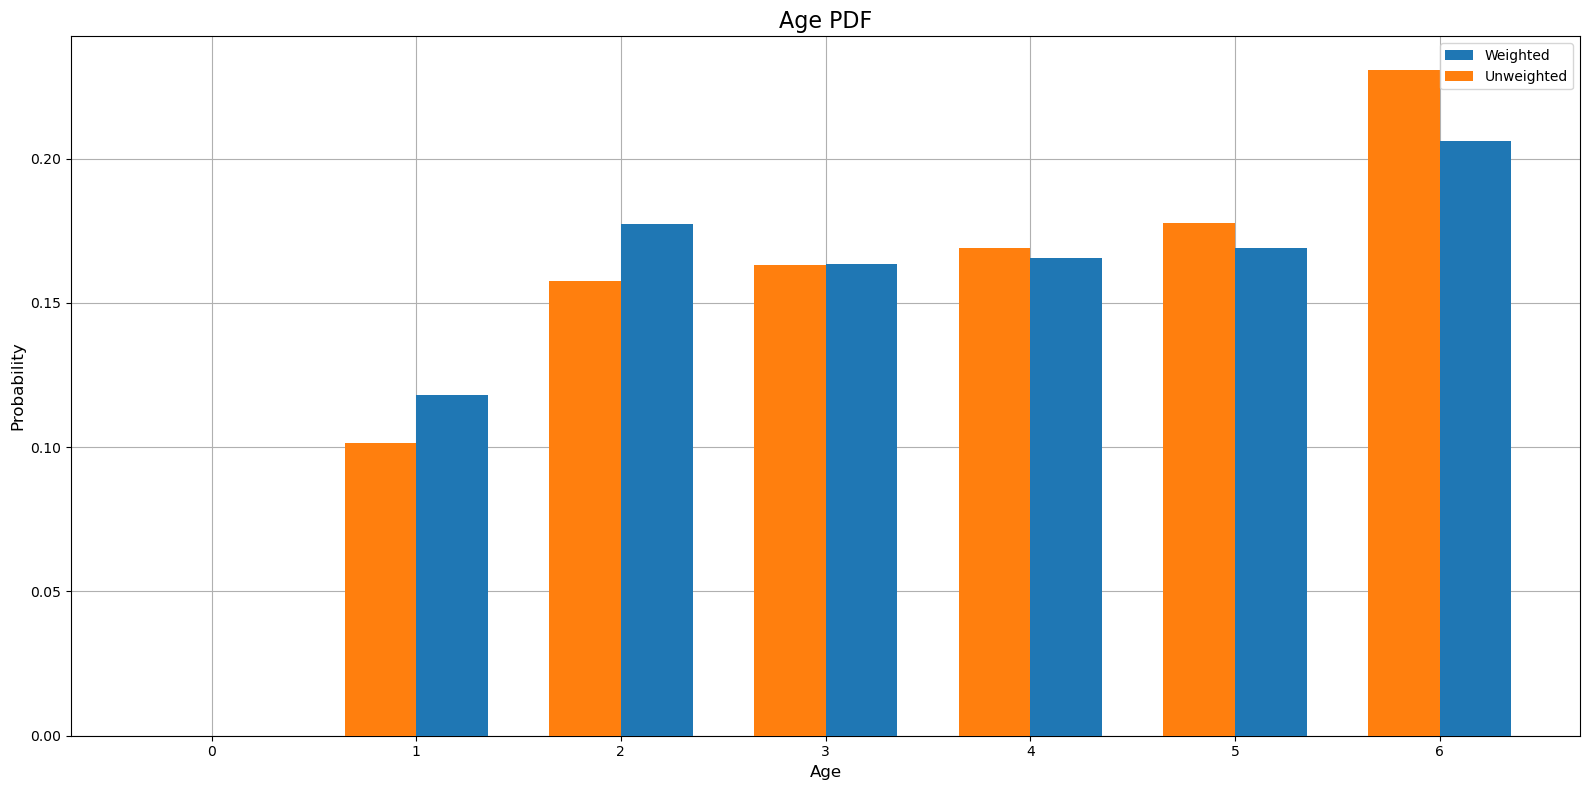

Unweighted PDF : [0.    0.102 0.158 0.163 0.169 0.178 0.231]
  Weighted PDF : [0.    0.118 0.177 0.163 0.166 0.169 0.206]


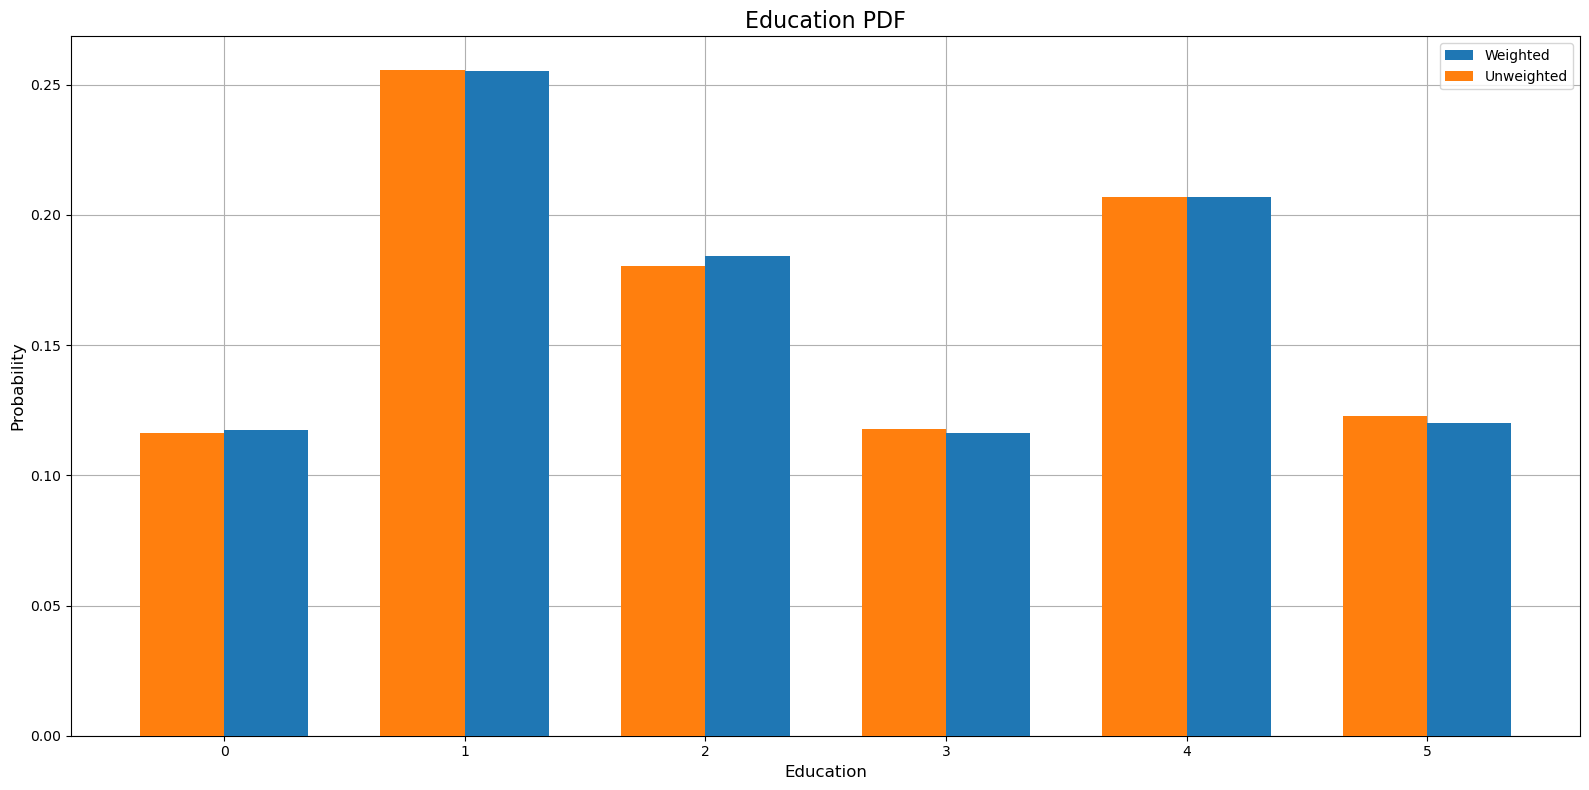

Unweighted PDF : [0.116 0.256 0.181 0.118 0.207 0.123]
  Weighted PDF : [0.117 0.255 0.184 0.116 0.207 0.12 ]


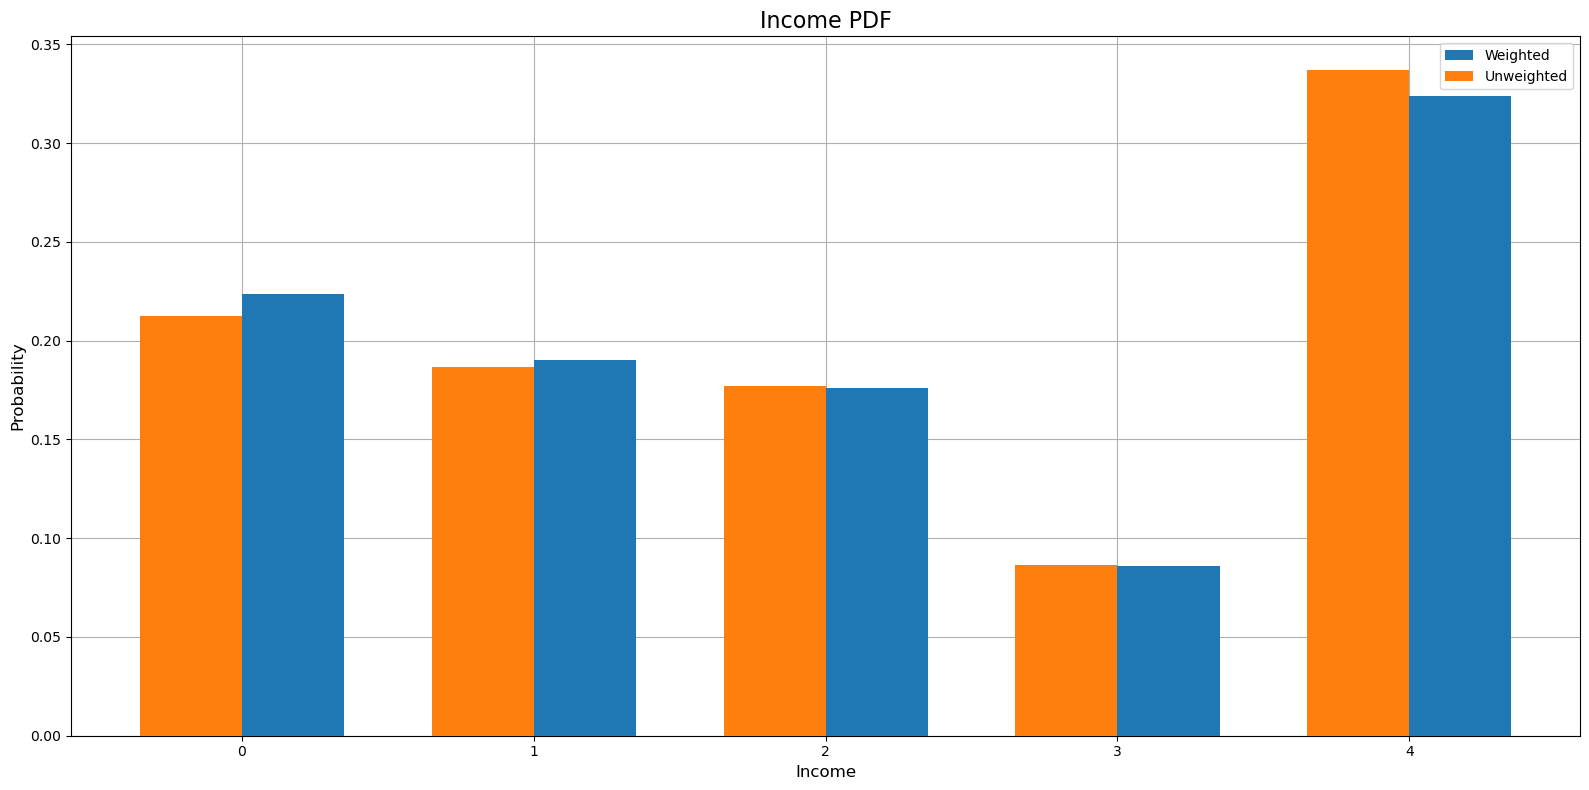

Unweighted PDF : [0.213 0.187 0.177 0.086 0.337]
  Weighted PDF : [0.224 0.19  0.176 0.086 0.324]


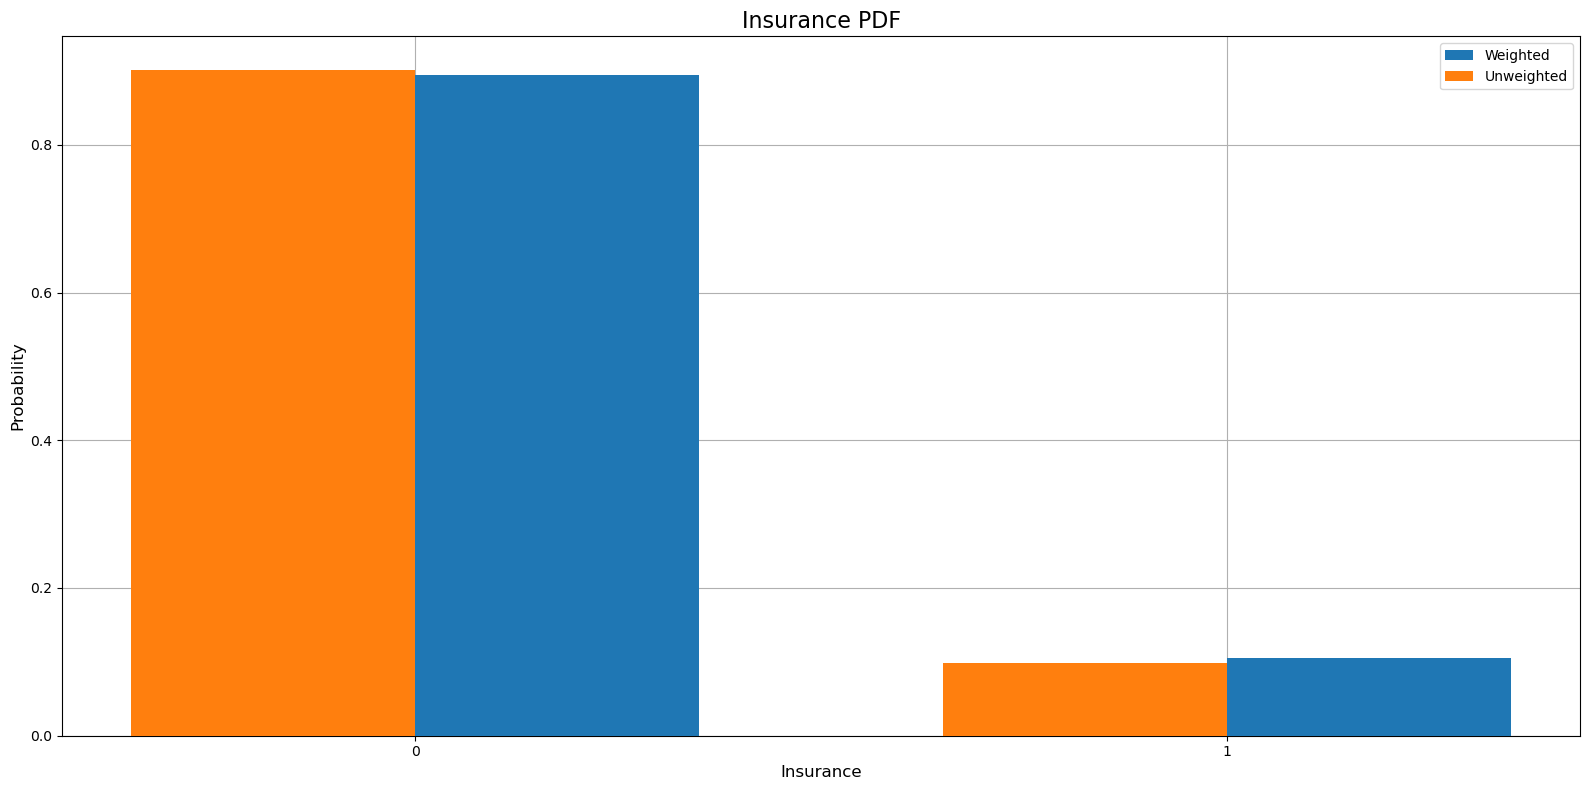

Unweighted PDF : [0.902 0.098]
  Weighted PDF : [0.895 0.105]


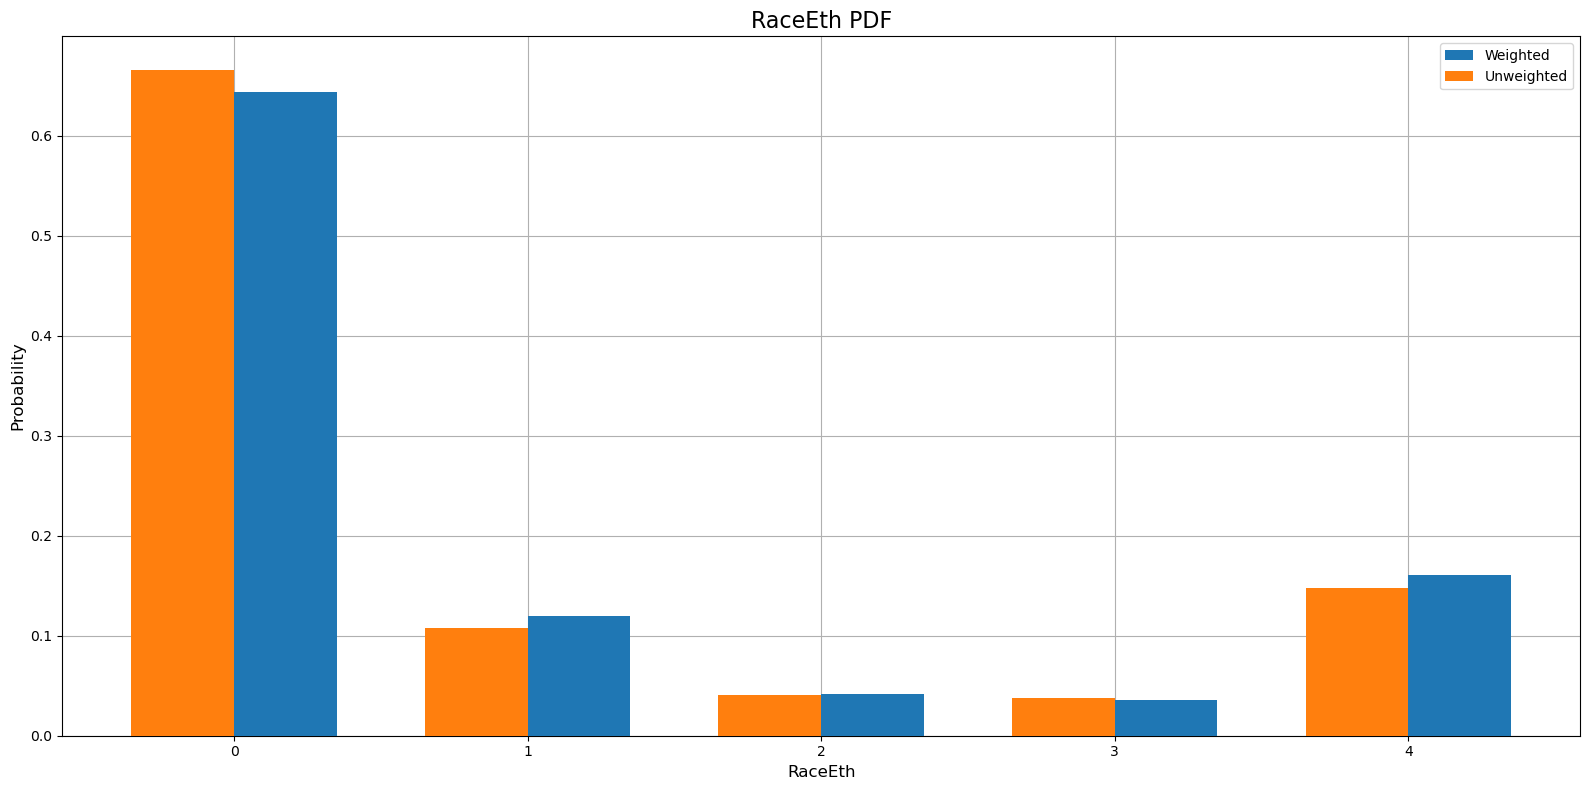

Unweighted PDF : [0.666 0.108 0.041 0.037 0.147]
  Weighted PDF : [0.643 0.119 0.042 0.035 0.16 ]


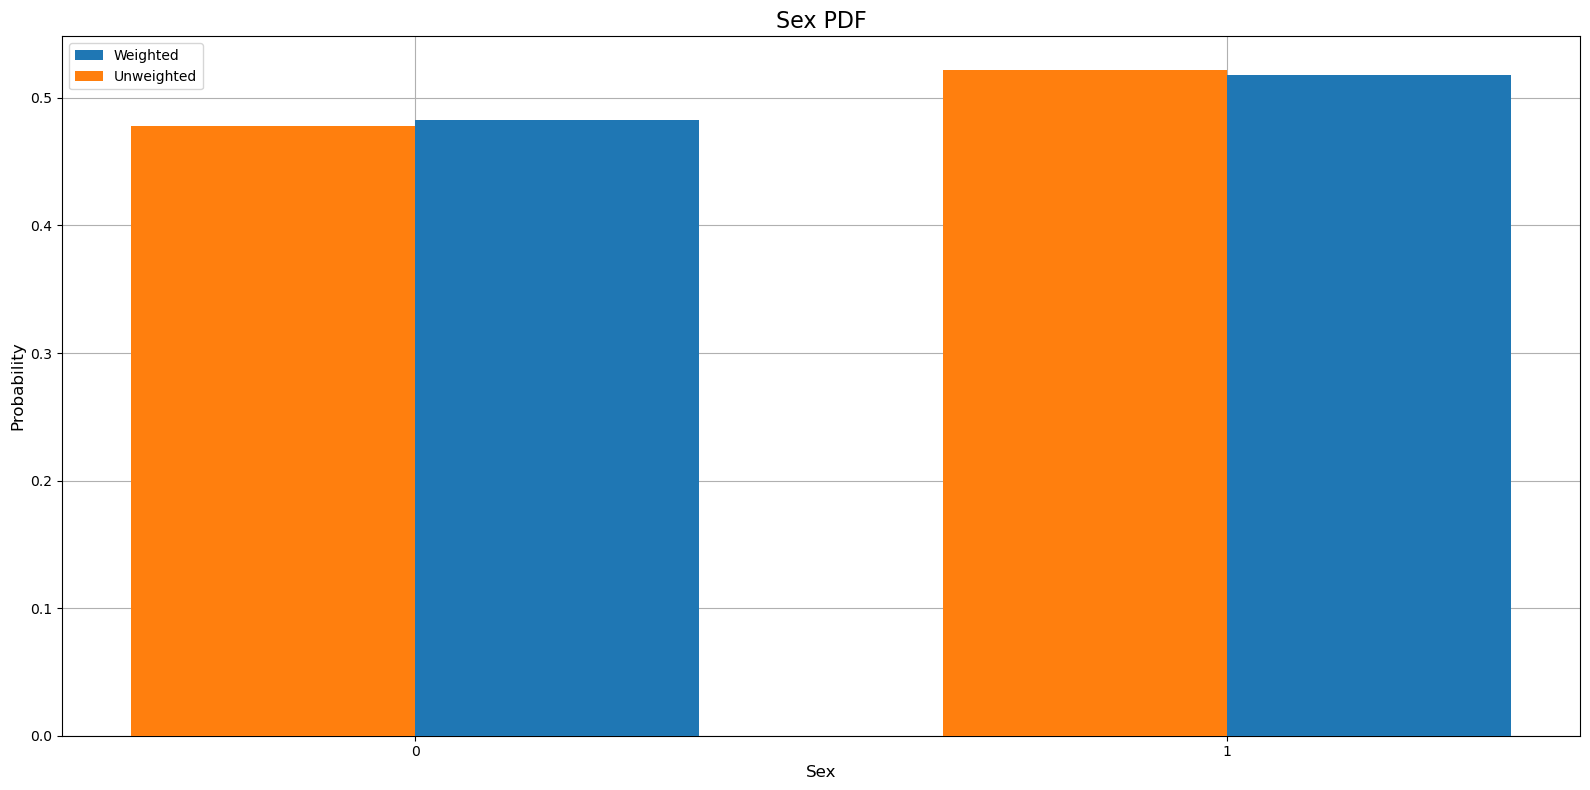

Unweighted PDF : [0.478 0.522]
  Weighted PDF : [0.482 0.518]


In [24]:
# display precision
P = 3

for col_name in final_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    plots.dual_histogram_from_pdfs(col_name, unweighted_pdfs[col_name], weighted_pdfs[col_name],
                                   labels=['Unweighted', 'Weighted'])
    
    print('Unweighted PDF : {0}'.format(np.array_str(unweighted_pdfs[col_name], precision=P)))
    print('  Weighted PDF : {0}'.format(np.array_str(weighted_pdfs[col_name],   precision=P)))

#### Find recoded NHIS tuples occurring in the recoded PUMS data

These are the only tuples that could have been obtained by sampling the PUMS population. More categories for each variable will result in fewer combinations that actually occur in the PUMS data.

In [25]:
# get dataframe cols in the same order (assumes the NHIS frame uses the PUMS names, which it does)
ordered_cols = [name for enumvar,name in PUMS_DATA]
for col in ordered_cols:
    assert col in pums_df
    assert col in final_df

# df1 is the reordered pums data
df1 = pums_df[ordered_cols]
# df2 is the reordered NHIS data
df2 = final_df[ordered_cols]
    
tuples1 = set(df1.itertuples(index=False, name=None))
print('There are {0} unique tuples in the PUMS data.'.format(len(tuples1)))

tuples2 = set(df2.itertuples(index=False, name=None))
print('There are {0} unique tuples in the NHIS data.'.format(len(tuples2)))

common_tuples = tuples2.intersection(tuples1)
print('Found {0} tuples in common.'.format(len(common_tuples)))

There are 2756 unique tuples in the PUMS data.
There are 2515 unique tuples in the NHIS data.
Found 1917 tuples in common.


In [26]:
# find the indices of the common tuples in the NHIS data
keep_indices = []
for indexed_tup in df2.itertuples(index=True, name=None):
    index = indexed_tup[0]
    tup = indexed_tup[1:]
    if tup in tuples1:
        keep_indices.append(index)
        
print('Found {0} recoded NHIS tuples that occur in the recoded PUMS population.'.format(len(keep_indices)))

# extract these indices from the final df
output_df = final_df.iloc[keep_indices]
output_df = output_df.reset_index(drop=True)
output_df

Found 36407 recoded NHIS tuples that occur in the recoded PUMS population.


,Age,Education,Income,Insurance,RaceEth,Sex,WTFA
0,4,2,1,0,0,0,5848
1,3,5,3,0,0,0,6009
2,3,4,3,0,0,1,5738
3,2,3,2,0,0,0,4238
4,2,2,1,0,0,1,3650
...,...,...,...,...,...,...,...
36402,1,2,0,0,0,1,5927
36403,1,3,0,0,0,1,7132
36404,3,4,0,0,0,1,7902
36405,5,4,2,0,0,1,7421


#### Write final dataframe to disk

In [27]:
# extract nhis_yyyy from the persons file
prefix = PERSONS_FILENAME[:len('nhis_yyyy')]
output_file = os.path.join(DATA_DIR, prefix + '_recoded' + '.csv')
output_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

Wrote file "data/nhis_2018_recoded.csv".
